# CRSS 2018 data analysis 

Objective: 
    #1) traffic accident statistics of CRSS 2018 data file
    #2) creating a model to predict the maximum injury severity in an accident, which can be a criteria of how dangerous an accident is
    #3) creating a model to predict the injury severity of a driver or passenger

In [1]:
# import packages
import pandas as pd
import geopandas as gpd
import numpy as np
import statsmodels.api as sm 
import statsmodels.formula.api as smf 
import matplotlib.pyplot as plt
%matplotlib  inline
import seaborn as sns; sns.set(color_codes=True)
import urllib.request
from shapely.geometry import Point
from pandas.io.json import json_normalize
import sklearn
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn import preprocessing 
import sklearn.feature_selection
import itertools
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import roc_curve, auc

                        Objective 1: Basic Statistics and informative graphs from the data

In [2]:
#importing data
ACCIDENT = pd.read_csv ('ACCIDENT.csv')
ACCIDENT.shape #This data has 48443 rows and 51 columns. 

(48443, 51)

In [3]:
ACCIDENT.columns

Index(['CASENUM', 'REGION', 'PSU', 'PJ', 'PSU_VAR', 'URBANICITY', 'STRATUM',
       'VE_TOTAL', 'VE_FORMS', 'PVH_INVL', 'PEDS', 'PERMVIT', 'PERNOTMVIT',
       'NUM_INJ', 'MONTH', 'YEAR', 'DAY_WEEK', 'HOUR', 'MINUTE', 'HARM_EV',
       'ALCOHOL', 'MAX_SEV', 'MAN_COLL', 'RELJCT1', 'RELJCT2', 'TYP_INT',
       'WRK_ZONE', 'REL_ROAD', 'LGT_COND', 'WEATHER1', 'WEATHER2', 'WEATHER',
       'SCH_BUS', 'INT_HWY', 'CF1', 'CF2', 'CF3', 'WKDY_IM', 'HOUR_IM',
       'MINUTE_IM', 'EVENT1_IM', 'MANCOL_IM', 'RELJCT1_IM', 'RELJCT2_IM',
       'LGTCON_IM', 'WEATHR_IM', 'MAXSEV_IM', 'NO_INJ_IM', 'ALCHL_IM',
       'PSUSTRAT', 'WEIGHT'],
      dtype='object')

Explanations of variables:
    #CASENUM: CASE ID (Not a variable)
    #VE_TOTAL: Number of Total Motor Vehicles involved in the crash  
    #VE_FORMS: Number of Motor Vehicles in Transport involved in the crash    
    #PVH_INVL: Number of Parked/Working Vehicles involved in the crash
    #PEDS: Number of Persons Not in Motor Vehicles
    #PERMVIT: Number of Persons in Motor Vehicles in Transport
    #PERNOTMVIT: Number of Persons Not in Motor Vehicles in Transport
    #NUM_INJ: Number Injured in Crash (Use imputed data)
    #MONTH: Month of Crash (Use imputed data)
    #YEAR: Year of Crash (Not a variable, all 2018)
    #DAY_WEEK: Day of Week (Use imputed data)
    #HOUR: Hour of Crash (Use imputed data)
    #MINUTE: Minute of Crash (Use imputed data)
    #HARM_EV: First Harmful Event (Use imputed data)
    #ALCOHOL: Alcohol Involved in Crash (Use imputed data)
    #MAX_SEV: Maximum Injury Severity in Crash (Use imputed data)
    #MAN_COLL: Manner of Collision (Use imputed data)
    #RELJCT1: Relation to Junction- Within Interchange Area (Use imputed data)
    #RELJCT2: Relation to Junction- Specific Location (Will not use this)
    #TYP_INT: Type of Intersection (Will not use this)
    #WRK_ZONE: Work Zone (Will not use this)
    #REL_ROAD: Relation to Trafficway (Will not use this)
    #LGT_COND: Light Condition (Use imputed data)
    #WEATHER: Atmospheric Conditions (Use imputed data)
    #SCH_BUS: School Bus Related (Will not use this)
    #INT_HWY: Interstate Highway (Will not use this)
    #CF: Related Factors- Crash Level (Will not use this)
    #WKDY_IM: Imputed Day of Week
    #HOUR_IM: Imputed Hour of Crash
    #MINUTE_IM: Imputed Minute of Crash
    #EVENT1_IM: Imputed First Harmful Event
    #MANCOL_IM: Imputed Manner of Collision
    #RELJCT1_IM: Imputed Relation to Junction- Within Interchange Area
    #RELJCT2_IM: Imputed Relation to Junction- Specific Location
    #LGTCON_IM: Imputed Light Condition
    #WEATHR_IM: Imputed Atmospheric Conditions
    #MAXSEV_IM: Imputed Maximum Injury Severity in Crash
    #NO_INJ_IM: Imputed Number Injured in Crash
    #ALCHL_IM: Imputed Alcohol Involved in Crash
    #WEIGHT :Weight of the case (Not a variable)

In [4]:
# Apply weights to ensure unbiased and robust estimate, here we use pd.sample method to randomly select case in ACCIDENT file with weights applied
# 242215 cases are selected randomly
# reference: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html
ACCIDENT_WEIGHT = ACCIDENT.sample(frac =5, weights=ACCIDENT['WEIGHT'], replace=True, random_state=960420)
ACCIDENT_WEIGHT.describe().T

,count,mean,std,min,25%,50%,75%,max
CASENUM,242215.0,2.018009e+11,240593.133459,2.018004e+11,2.018007e+11,2.018009e+11,2.018011e+11,2.018014e+11
REGION,242215.0,2.701980e+00,0.891883,1.000000e+00,2.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00
PSU,242215.0,4.758306e+01,19.730190,1.000000e+01,3.200000e+01,4.800000e+01,6.300000e+01,8.300000e+01
PJ,242215.0,1.401194e+03,1061.486029,4.500000e+01,4.570000e+02,1.098000e+03,2.091000e+03,4.125000e+03
PSU_VAR,242215.0,5.126410e+01,31.555853,1.000000e+01,3.200000e+01,4.800000e+01,6.500000e+01,2.140000e+02
URBANICITY,242215.0,1.229238e+00,0.420344,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00
STRATUM,242215.0,8.588630e+00,1.716717,2.000000e+00,8.000000e+00,9.000000e+00,1.000000e+01,1.000000e+01
VE_TOTAL,242215.0,1.857003e+00,0.589925,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,1.500000e+01
VE_FORMS,242215.0,1.788518e+00,0.595178,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,1.500000e+01
PVH_INVL,242215.0,6.848461e-02,0.304729,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+01


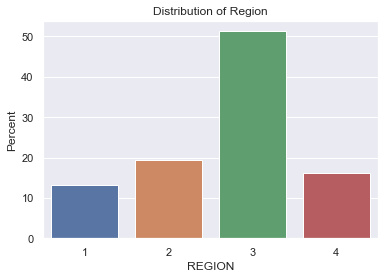

In [5]:
ACCIDENT_WEIGHT.REGION.value_counts()  #It means this whole data has 4 regions and they divided it into 1, 2, 3, 4

# shown in percentage
percentage = lambda i: len(i) / float(len(ACCIDENT_WEIGHT)) * 100

ax = sns.barplot(x='REGION', y='REGION',data=ACCIDENT_WEIGHT, estimator=percentage)
ax.set(title = "Distribution of Region", ylabel="Percent")
plt.show()

#1 Northeast (PA, NJ, NY, NH, VT, RI, MA, ME, CT),
#2 Midwest (OH, IN, IL, MI, WI, MN, ND, SD, NE, IA, MO, KS),
#3 South (MD, DE, DC, WV, VA, KY, TN, NC, SC, GA, FL, AL, MS, LA, AR, OK, TX),
#4 West (MT, ID, WA, OR, CA, NV, NM, AZ, UT, CO, WY, AK, HI)

The graph above (No of accident vs Region) telling us that Region 3 has the highest number of accident incidents which includes South part of USA (MD, DE, DC, WV, VA, KY, TN, NC, SC, GA, FL, AL, MS, LA, AR, OK, TX)

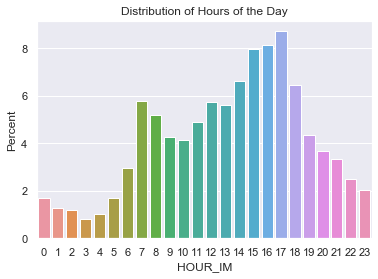

In [6]:
percentage = lambda i: len(i) / float(len(ACCIDENT_WEIGHT)) * 100

ax = sns.barplot(x='HOUR_IM', y='HOUR_IM',data=ACCIDENT_WEIGHT, estimator=percentage)
ax.set(title = "Distribution of Hours of the Day", ylabel="Percent")
plt.show()

At 5PM we had highest number of accident incident whereas at 3 AM in the morning had the lowest

Maximum number of accidents happened between 3 to 6 PM of the day.This is often because of the high volume of vehicles on the road
Question would be number of injury due to this accident incident follows the same trend?

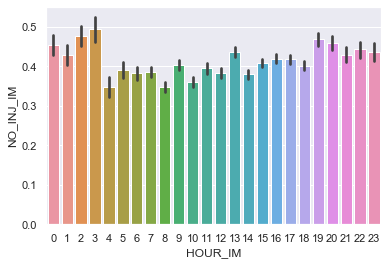

In [7]:
#Traffic Crashes and Injuries by Hour of the Day

ax = sns.barplot(x="HOUR_IM", y="NO_INJ_IM", data=ACCIDENT_WEIGHT)  
#Number of injury vs Hour of the day

The graph shows the number of injury does not change much at different hours of the day 

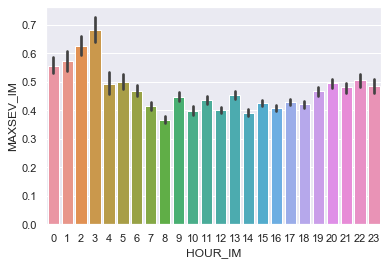

In [8]:
#Maximum severity vs Hour of the day
#0:No Apparent Injury | 1:Possible Injury | 2: Suspected Minor Injury | 3：Suspected Serious Injury | 4：Fatal
ax = sns.barplot(x="HOUR_IM", y="MAXSEV_IM", data=ACCIDENT_WEIGHT[ACCIDENT_WEIGHT.MAXSEV_IM<=4]) 

The graph shows an opposite trend with the number of the accidents at the different times of a day, which mean the accidents happeded from the midnight to early morning are most dangerous.

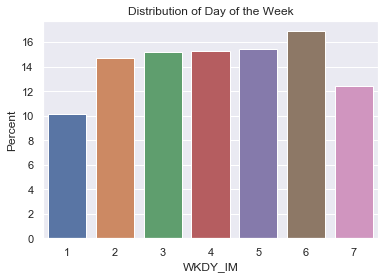

In [9]:
#Traffic Crashes and Injuries by Day of the Week
percentage = lambda i: len(i) / float(len(ACCIDENT_WEIGHT)) * 100

ax = sns.barplot(x='WKDY_IM', y='WKDY_IM',data=ACCIDENT_WEIGHT, estimator=percentage)
ax.set(title = "Distribution of Day of the Week", ylabel="Percent")
plt.show()

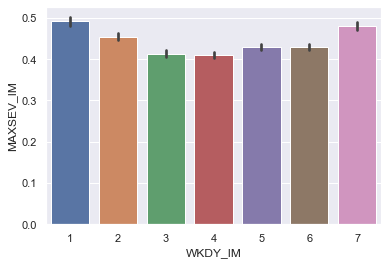

In [10]:
#Maximum severity vs Day of the Week: 1 Sunday 2 Monday ...   
ax = sns.barplot(x="WKDY_IM", y="MAXSEV_IM", data=ACCIDENT_WEIGHT[ACCIDENT_WEIGHT.MAXSEV_IM<=4]) 

Graphs show that Saturday and Sunday have the least number of accidents, nevertheless, accidents on Saturday and Sunday are most dangerous.

ACCIDENT_WEIGHT.LGTCON_IM.value_counts() #1 is daylight. most of the incident happened during daylight
percentage = lambda i: len(i) / float(len(ACCIDENT_WEIGHT)) * 100

ax = sns.barplot(x='LGTCON_IM', y='LGTCON_IM',data=ACCIDENT_WEIGHT, estimator=percentage)
ax.set(title = "Distribution of Hours of the Light Condition", ylabel="Percent")
plt.show()

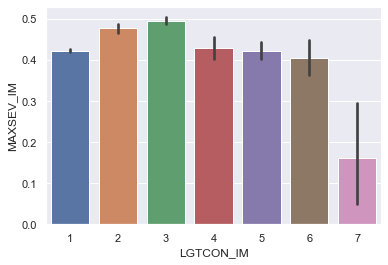

In [11]:
#Maximum severity vs Light Condition
ax = sns.barplot(x="LGTCON_IM", y="MAXSEV_IM", data=ACCIDENT_WEIGHT[ACCIDENT_WEIGHT.MAXSEV_IM<=4])
#1: dayligh | 2: Dark – Not Lighted | 3:Dark – Lighted | 4: Dawn |  5: Dust | 6: Dark – Unknown Lighting | 7: Other

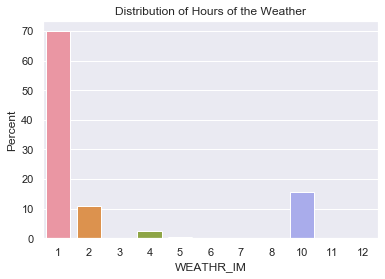

In [12]:
ACCIDENT_WEIGHT.WEATHER.value_counts() 
percentage = lambda i: len(i) / float(len(ACCIDENT_WEIGHT)) * 100

ax = sns.barplot(x='WEATHR_IM', y='WEATHR_IM',data=ACCIDENT_WEIGHT, estimator=percentage)
ax.set(title = "Distribution of Hours of the Weather", ylabel="Percent")
plt.show()

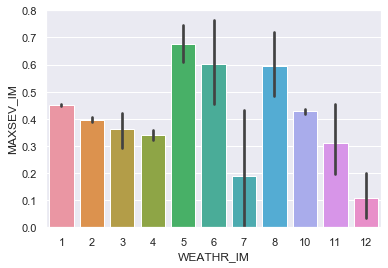

In [13]:
ax = sns.barplot(x="WEATHR_IM", y="MAXSEV_IM", data=ACCIDENT_WEIGHT[ACCIDENT_WEIGHT.MAXSEV_IM<=4])
#1:Clear | 2:Rain | 3:Sleet or Hail | 4:Snow | 5:Fog, Smog, Smoke | 6:Severe Crosswinds | 7: Blowing Sand, Soil, Dirt
# 8：Other| 10: Cloudy | 11: Blowing Snow | 12: Freezing Rain or Drizzle

When looking at the weather condition and the light condition, we see that most accidents happens during the sunny day and the daytime. However, this is becaues there are much more cars during the daytime and much more sunny days than other weather. So we look at the relationship between the maximum injury severity and the weather or light condition. The graphs show that when it's dark or foggy, the accidents are most dangerous.

Next question would be at night time what could be the reason of this large number of injured people? Is it due to the driver was drunk?


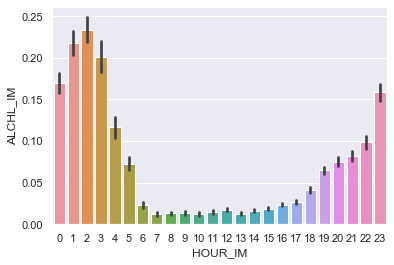

In [14]:
ACCIDENT_WEIGHT.ALCHL_IM.replace({2: 0}, inplace=True)
sns.barplot(x="HOUR_IM", y="ALCHL_IM",data=ACCIDENT_WEIGHT)

Grah shows that the accidents happened between 7pm and 5am are more likely to be involved with alcohol. More than 1/4 of the accdents happens at 2am are invloved with alcohol.

Let's see how the maximum injury severity is related to the alcohol involvement.

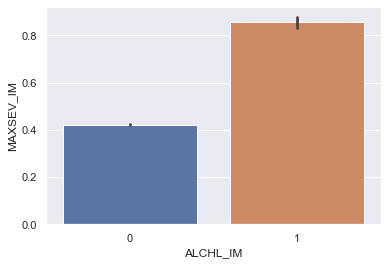

In [15]:
ax = sns.barplot(x="ALCHL_IM", y="MAXSEV_IM", data=ACCIDENT_WEIGHT[ACCIDENT_WEIGHT.MAXSEV_IM<=4])

It's clearly that the accidents with alcohol invloved are more likely to have injury.

Now let's look at the how the first harmful event related to the maximum injury severity.
There are four primary categories in the first harmful events, and many secondary categories, so we choose those first harmful events whose frequencies are larger than 0.007:
                      #(Collision with)
    #12    0.703722    Motor Vehicle In-Transport  
    #14    0.053320    Parked Motor Vehicle  
    #11    0.046306    Live Animal  
    #34    0.020996    Ditch  
    #30    0.017158    Utility Pole/Light Support  
    #42    0.016324    Tree (Standing Only)  
    #33    0.013827    Curb  
    #1     0.013602    (Non-Collision) Rollover/Overturn  
    #24    0.012516    Guardrail Face  
    #8     0.010565    Pedestrian  
    #59    0.010024    Traffic Sign Support  
    #38    0.008022    Fence  
    #35    0.007413    Embankment  
    #9     0.007281    Pedalcyclist  
    #25    0.007215    Concrete Traffic Barrier  

In [16]:
a = ACCIDENT_WEIGHT.EVENT1_IM.value_counts()
a/len(ACCIDENT_WEIGHT)

12    0.703326
14    0.053411
11    0.045749
34    0.020709
30    0.016721
42    0.016407
33    0.014132
1     0.013740
24    0.012625
8     0.010627
59    0.009962
38    0.008278
9     0.007625
35    0.007493
25    0.007233
18    0.006197
53    0.005912
43    0.004843
32    0.003270
31    0.003191
57    0.003171
54    0.002911
52    0.002667
39    0.002399
40    0.001490
19    0.001428
23    0.001201
2     0.001078
48    0.000813
46    0.000809
7     0.000768
93    0.000739
15    0.000718
5     0.000714
41    0.000669
44    0.000665
51    0.000656
26    0.000632
58    0.000607
91    0.000578
50    0.000553
16    0.000508
20    0.000504
17    0.000446
72    0.000433
45    0.000413
3     0.000314
21    0.000285
73    0.000149
10    0.000140
6     0.000070
55    0.000021
Name: EVENT1_IM, dtype: float64

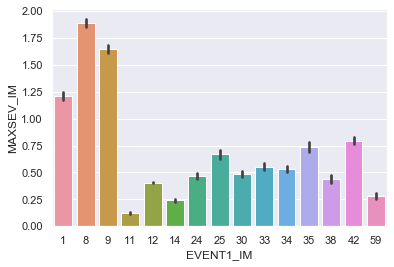

In [17]:
ACCIDENT_WEIGHT = ACCIDENT_WEIGHT.loc[ACCIDENT_WEIGHT['EVENT1_IM'].isin([12,14,11,34,30,42,33,1,24,8,59,38,35,9,25])]
ax = sns.barplot(x="EVENT1_IM", y="MAXSEV_IM", data=ACCIDENT_WEIGHT[ACCIDENT_WEIGHT.MAXSEV_IM<=4])

The graph shows that the accidents with rollover/overturn, collision with pedestrian or pedalcyclist are most dangerous, while the collisions with live animal, parked vehicle or traffic sigh are relatively safe.

Now let's look at the how the manner of collision related to the maximum injury severity.
    # 0 Not Collision with Motor Vehicle in Transport
    # 1 Front-to-Rear
    # 2 Front-to-Front
    # 6 Angle
    # 7 Sideswipe, Same Direction
    # 8 Sideswipe, Opposite Direction
    # 9 Rear-to-Side
    # 10 Rear-to-Rear
    # 11 Other

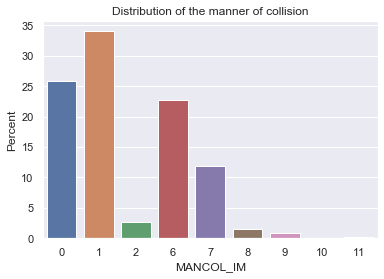

In [18]:
percentage = lambda i: len(i) / float(len(ACCIDENT_WEIGHT)) * 100

ax = sns.barplot(x='MANCOL_IM', y='MANCOL_IM',data=ACCIDENT_WEIGHT, estimator=percentage)
ax.set(title = "Distribution of the manner of collision", ylabel="Percent")
plt.show()

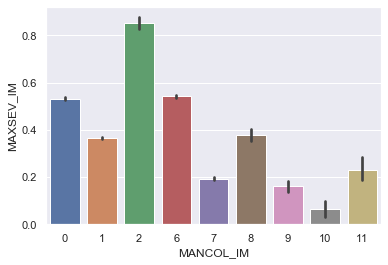

In [19]:
ax = sns.barplot(x="MANCOL_IM", y="MAXSEV_IM", data=ACCIDENT_WEIGHT[ACCIDENT_WEIGHT.MAXSEV_IM<=4])

Graphs show that Front-to-Front collision happens rarely, but it is extremely dangerous. Not Collision with Motor Vehicle in Transport is also dangerous because it may inlove rollover/overturn, collision with pedestrian or pedalcyclist.

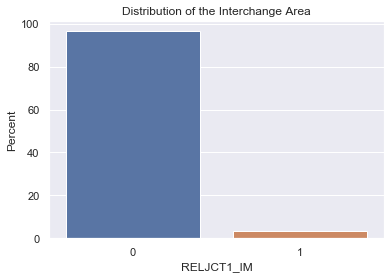

In [20]:
percentage = lambda i: len(i) / float(len(ACCIDENT_WEIGHT)) * 100

ax = sns.barplot(x='RELJCT1_IM', y='RELJCT1_IM',data=ACCIDENT_WEIGHT, estimator=percentage)
ax.set(title = "Distribution of the Interchange Area", ylabel="Percent")
plt.show()

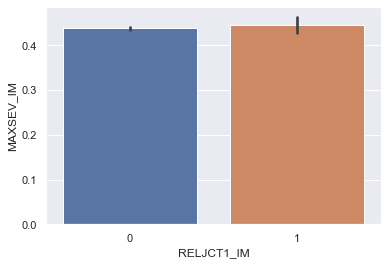

In [21]:
ax = sns.barplot(x="RELJCT1_IM", y="MAXSEV_IM", data=ACCIDENT_WEIGHT[ACCIDENT_WEIGHT.MAXSEV_IM<=4])

Accidents happen within interchange area or not does not change the maximum injury severity very much.

Now let's look at the how the accidents location related to the maximum injury severity.
    #1 Non-Junction
    #2 Intersection
    #3 Intersection Related
    #4 Driveway Access
    #5 Entrance/Exit Ramp Related
    #6 Railway Grade Crossing
    #7 Crossover Related
    #8 Driveway Access Related
    #16 Shared-Use Path Crossing
    #17 Acceleration/Deceleration Lane
    #18 Through Roadway
    #19 Other Location Within Interchange Area
    #20 Entrance/Exit Ramp

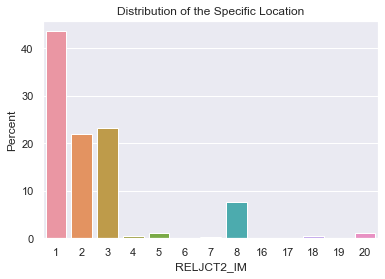

In [22]:
percentage = lambda i: len(i) / float(len(ACCIDENT_WEIGHT)) * 100

ax = sns.barplot(x='RELJCT2_IM', y='RELJCT2_IM',data=ACCIDENT_WEIGHT, estimator=percentage)
ax.set(title = "Distribution of the Specific Location", ylabel="Percent")
plt.show()

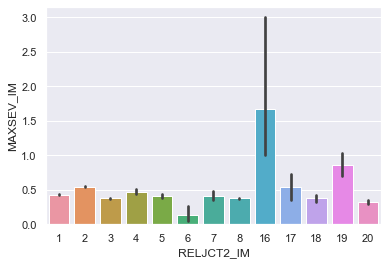

In [23]:
ax = sns.barplot(x="RELJCT2_IM", y="MAXSEV_IM", data=ACCIDENT_WEIGHT[ACCIDENT_WEIGHT.MAXSEV_IM<=4])

Accidents happen at the ntersection are more dangerous. Category 16 is very high, but the reason may be the lack of data.

             Objective 2: Build a model to predict the maximum injury severity in an accident

In [24]:
#data pre-processing
ACCIDENT_WEIGHT.shape

(229629, 51)

In [25]:
ACCIDENT_WEIGHT = ACCIDENT_WEIGHT[['CASENUM','VE_FORMS','PEDS','PERMVIT','WKDY_IM', 'HOUR_IM', 'EVENT1_IM', 'MANCOL_IM', 'RELJCT1_IM', 'RELJCT2_IM',
       'LGTCON_IM', 'WEATHR_IM', 'MAXSEV_IM', 'NO_INJ_IM', 'ALCHL_IM']]

    #CASENUM: CASE ID 
    #VE_FORMS: Number of Motor Vehicles in Transport involved in the crash
    #PEDS: Number of Persons Not in Motor Vehicles
    #PERMVIT: Number of Persons in Motor Vehicles in Transport
    #WKDY_IM: Imputed Day of Week
    #HOUR_IM: Imputed Hour of Crash
    #EVENT1_IM: Imputed First Harmful Event
    #MANCOL_IM: Imputed Manner of Collision
    #RELJCT1_IM: Imputed Relation to Junction- Within Interchange Area
    #RELJCT2_IM: Imputed Relation to Junction- Specific Location
    #LGTCON_IM: Imputed Light Condition
    #WEATHR_IM: Imputed Atmospheric Conditions
    #MAXSEV_IM: Imputed Maximum Injury Severity in Crash
    #NO_INJ_IM: Imputed Number Injured in Crash
    #ALCHL_IM: Imputed Alcohol Involved in Crash

In [26]:
ACCIDENT_WEIGHT = ACCIDENT_WEIGHT.loc[ACCIDENT_WEIGHT.MAXSEV_IM<=4]

In [27]:
ACCIDENT_WEIGHT.columns

Index(['CASENUM', 'VE_FORMS', 'PEDS', 'PERMVIT', 'WKDY_IM', 'HOUR_IM',
       'EVENT1_IM', 'MANCOL_IM', 'RELJCT1_IM', 'RELJCT2_IM', 'LGTCON_IM',
       'WEATHR_IM', 'MAXSEV_IM', 'NO_INJ_IM', 'ALCHL_IM'],
      dtype='object')

Transfor hour of the day into 2 categories: 
    #0: daytime     6am-8pm
    #1: nighttime   8pm-6am

In [28]:
ACCIDENT_WEIGHT.loc[ACCIDENT_WEIGHT['HOUR_IM'].isin([6,7,8,9,10,11,12,13,14,15,16,17,18,19]), 'HOUR_IM'] = 0
ACCIDENT_WEIGHT.loc[ACCIDENT_WEIGHT['HOUR_IM'].isin([20,21,22,23,24,1,2,3,4,5]), 'HOUR_IM'] = 1

ACCIDENT_WEIGHT.HOUR_IM.value_counts()

0    189862
1     38841
Name: HOUR_IM, dtype: int64

Transfor day of the week into 2 categories: 
    #0: weekday     Monday-Friday
    #1: weekend   Saturday Sunday

In [29]:
ACCIDENT_WEIGHT.loc[ACCIDENT_WEIGHT['WKDY_IM'].isin([2,3,4,5,6]), 'WKDY_IM'] = 0
ACCIDENT_WEIGHT.loc[ACCIDENT_WEIGHT['WKDY_IM'].isin([1,7]), 'WKDY_IM'] = 1

ACCIDENT_WEIGHT.WKDY_IM.value_counts()

0    177850
1     50853
Name: WKDY_IM, dtype: int64

 Transform categorical variablesinto dummy binary variables.

In [30]:
ACCIDENT_WEIGHT_DUMMY = ACCIDENT_WEIGHT[['VE_FORMS', 'PEDS', 'PERMVIT', 'WKDY_IM', 'HOUR_IM',
       'EVENT1_IM', 'MANCOL_IM', 'RELJCT1_IM', 'RELJCT2_IM', 'LGTCON_IM', 'WEATHR_IM', 'MAXSEV_IM', 'ALCHL_IM']]
ACCIDENT_WEIGHT_DUMMY = pd.get_dummies(data = ACCIDENT_WEIGHT_DUMMY, columns = ['EVENT1_IM', 'MANCOL_IM', 
        'RELJCT1_IM','RELJCT2_IM', 'LGTCON_IM', 'WEATHR_IM']).copy()
ACCIDENT_WEIGHT_DUMMY.shape  # Totally 63 variables

(228703, 64)

In [31]:
ACCIDENT_WEIGHT_DUMMY.reset_index(inplace = True)

In [32]:
ACCIDENT_WEIGHT_DUMMY.corr()['MAXSEV_IM'].sort_values()

MANCOL_IM_7    -0.113678
EVENT1_IM_11   -0.089241
EVENT1_IM_12   -0.069740
MANCOL_IM_1    -0.066040
EVENT1_IM_14   -0.060865
                  ...   
EVENT1_IM_1     0.118156
EVENT1_IM_9     0.136091
EVENT1_IM_8     0.193694
PEDS            0.231871
MAXSEV_IM       1.000000
Name: MAXSEV_IM, Length: 65, dtype: float64

It can be seen that the highest positive correlations are pedestrian/pedalcyclist related, rollover, front-to-front collision,
alcohol involved, the highest negative correlations are same direction sideswide collision, collision with live animal, etc.

In [33]:
# split our data
X = ACCIDENT_WEIGHT_DUMMY.drop(['MAXSEV_IM'], axis=1).values
y = ACCIDENT_WEIGHT_DUMMY['MAXSEV_IM'].values

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=1)
X_train, X_test, y_train, y_test

(array([[22129,     2,     0, ...,     0,     0,     0],
        [15437,     2,     0, ...,     0,     0,     0],
        [40666,     2,     0, ...,     1,     0,     0],
        ...,
        [26195,     2,     0, ...,     0,     0,     0],
        [27050,     1,     0, ...,     0,     0,     0],
        [ 1900,     3,     0, ...,     0,     0,     0]], dtype=int64),
 array([[41093,     2,     0, ...,     0,     0,     0],
        [21634,     2,     0, ...,     1,     0,     0],
        [ 5777,     2,     0, ...,     0,     0,     0],
        ...,
        [ 5213,     2,     0, ...,     0,     0,     0],
        [26170,     2,     0, ...,     0,     0,     0],
        [48344,     1,     0, ...,     0,     0,     0]], dtype=int64),
 array([1, 1, 0, ..., 0, 0, 0], dtype=int64),
 array([0, 0, 1, ..., 0, 0, 0], dtype=int64))

Try logistic regression, with solver = 'lbfgs', set multi_class to multinomial so we can predict multiclass variable.

In [34]:
## Fit model
clf = LogisticRegression(max_iter = 10000, solver = 'lbfgs', multi_class = 'multinomial', random_state = 960420)
clf.fit(X_train, y_train)

## Generate predictions
predicted = clf.predict(X_test)
    
## Compare to actual outcomes and return precision
print('Precision: ', (round(precision_score(y_test, predicted,average = 'micro')*100,1)))
report = sklearn.metrics.classification_report(y_test, predicted)
print(report)

Precision:  71.7
              precision    recall  f1-score   support

           0       0.72      1.00      0.84     41016
           1       0.00      0.00      0.00      9422
           2       0.00      0.00      0.00      5061
           3       0.00      0.00      0.00      1417
           4       0.00      0.00      0.00       260

    accuracy                           0.72     57176
   macro avg       0.14      0.20      0.17     57176
weighted avg       0.51      0.72      0.60     57176



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Results show that all predicted values are 0. 

Try logistic regression, with solver = 'newton-cg'

In [35]:
## Fit model
clf = LogisticRegression(max_iter = 10000, solver = 'newton-cg', multi_class = 'multinomial', random_state = 960420)
clf.fit(X_train, y_train)

## Generate predictions
predicted = clf.predict(X_test)
    
## Compare to actual outcomes and return precision
print('Precision: ', (round(precision_score(y_test, predicted,average = 'micro')*100,1)))
report = sklearn.metrics.classification_report(y_test, predicted)
print(report)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Precision:  72.5
              precision    recall  f1-score   support

           0       0.74      0.99      0.85     41016
           1       0.40      0.05      0.08      9422
           2       0.37      0.05      0.09      5061
           3       0.00      0.00      0.00      1417
           4       0.19      0.01      0.02       260

    accuracy                           0.73     57176
   macro avg       0.34      0.22      0.21     57176
weighted avg       0.63      0.73      0.63     57176



C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:426: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


Though the algorithm doesn't converge at 10000 iteration, we now have predicted values of 1,2,3,4. The precision is still very low.

Try neural network 

In [36]:
clf = MLPClassifier(random_state = 1)
clf.fit(X_train, y_train)

## Generate predictions
predicted = clf.predict(X_test)
    
## Compare to actual outcomes and return precision
print('Precision: ', (round(precision_score(y_test, predicted,average = 'micro')*100,1)))
report = sklearn.metrics.classification_report(y_test, predicted)
print(report)

Precision:  71.9
              precision    recall  f1-score   support

           0       0.72      1.00      0.84     41016
           1       0.91      0.01      0.01      9422
           2       1.00      0.01      0.01      5061
           3       0.62      0.00      0.01      1417
           4       0.00      0.00      0.00       260

    accuracy                           0.72     57176
   macro avg       0.65      0.20      0.17     57176
weighted avg       0.77      0.72      0.60     57176



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The precision is low. From 'recall' in the report we can see that most cases whose maximum injury severity are 1,2,3,4 cannot be correctly predicted

Random forest classifier is an excellent classifier for predicting multi-class dependent variable. Now try Random Forest Classifiers with default settings

In [37]:
## Fit model
clf = RandomForestClassifier(random_state = 960420)
clf.fit(X_train, y_train)

## Generate predictions
predicted = clf.predict(X_test)
    
## Compare to actual outcomes and return precision
print('Precision: ', (round(precision_score(y_test, predicted,average = 'micro')*100,1)))
report = sklearn.metrics.classification_report(y_test, predicted)
print(report)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Precision:  96.5
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     41016
           1       0.95      0.93      0.94      9422
           2       0.93      0.90      0.92      5061
           3       0.88      0.62      0.73      1417
           4       0.88      0.61      0.72       260

    accuracy                           0.97     57176
   macro avg       0.92      0.81      0.86     57176
weighted avg       0.96      0.97      0.96     57176



'Report' shows that random forest classifier does much better than the other classifiers. Precision gets to 96.5
All non-injury and more than 90% possible injury/suspected minor injury cases are correctly predicted, and more than 60% of suspected serious injury/fatal cases are correctly predicted.

Now we change some settings to see if we can improve the precision. Set n_estimators = 20, max_features = 10.

In [38]:
## Fit model
clf = RandomForestClassifier(random_state = 960420, n_estimators = 20, max_features = 10)
clf.fit(X_train, y_train)

## Generate predictions
predicted = clf.predict(X_test)
    
## Compare to actual outcomes and return precision
print('Precision: ', (round(precision_score(y_test, predicted,average = 'micro')*100,1)))
report = sklearn.metrics.classification_report(y_test, predicted)
print(report)

Precision:  96.9
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     41016
           1       0.96      0.94      0.95      9422
           2       0.94      0.91      0.92      5061
           3       0.88      0.65      0.75      1417
           4       0.87      0.63      0.73       260

    accuracy                           0.97     57176
   macro avg       0.92      0.82      0.87     57176
weighted avg       0.97      0.97      0.97     57176



Precision improves

Now we use pipeline to help us determine the parameters of random forest classifier. Meanwhile use cross-validation to help us avoid over-fitting 
    #feature_selection_k = [1,6,11,16,21,26,31,36,41,46,51,56,61]
    #n_estimators = [80, 90, 100]
    #min_samples_split = [2,4]
With the combination of these three parameters, we have totally 78 candidates.

In [39]:
select = sklearn.feature_selection.SelectKBest(k='all')
clf = sklearn.ensemble.RandomForestClassifier(random_state=1)

steps = [('feature_selection', select),
         ('random_forest', clf)]

pipeline = sklearn.pipeline.Pipeline(steps) 

parameters = dict(feature_selection__k= list(range(1,64,5)), # listing each one
              random_forest__n_estimators=list(range(80,101,10)),  # generating a list up, skipping by two
              random_forest__min_samples_split=list(range(2,5,2))) 

cv = GridSearchCV(pipeline, param_grid=parameters, verbose=True)

cv.fit(X_train, y_train)
predicted = cv.predict(X_test)
report = sklearn.metrics.classification_report(y_test, predicted)
print(report)

Fitting 3 folds for each of 78 candidates, totalling 234 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 234 out of 234 | elapsed: 35.5min finished


              precision    recall  f1-score   support

           0       0.98      1.00      0.99     41016
           1       0.96      0.95      0.95      9422
           2       0.94      0.92      0.93      5061
           3       0.89      0.67      0.76      1417
           4       0.85      0.63      0.73       260

    accuracy                           0.97     57176
   macro avg       0.93      0.83      0.87     57176
weighted avg       0.97      0.97      0.97     57176



In [40]:
print('Precision: ', (round(precision_score(y_test, predicted,average = 'micro')*100,1)))

Precision:  97.3


In [41]:
pd.set_option('max_row',500)
pd.DataFrame(cv.cv_results_).sort_values('rank_test_score',ascending=True)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_feature_selection__k,param_random_forest__min_samples_split,param_random_forest__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
56,14.504539,0.136554,2.010510,0.035398,46,2,100,"{'feature_selection__k': 46, 'random_forest__m...",0.950296,0.951728,0.950361,0.950795,0.000660,1
55,13.046145,0.134781,1.818095,0.018888,46,2,90,"{'feature_selection__k': 46, 'random_forest__m...",0.950278,0.951606,0.950204,0.950696,0.000644,2
54,11.558968,0.090113,1.609411,0.021245,46,2,80,"{'feature_selection__k': 46, 'random_forest__m...",0.950366,0.951431,0.950134,0.950643,0.000565,3
62,15.468740,0.061312,2.012676,0.039778,51,2,100,"{'feature_selection__k': 51, 'random_forest__m...",0.950068,0.951728,0.950011,0.950603,0.000796,4
68,15.982679,0.026840,2.078394,0.015313,56,2,100,"{'feature_selection__k': 56, 'random_forest__m...",0.950033,0.951676,0.950064,0.950591,0.000767,5
50,13.985859,0.125989,1.975358,0.040252,41,2,100,"{'feature_selection__k': 41, 'random_forest__m...",0.950470,0.951641,0.949592,0.950568,0.000839,6
49,12.643327,0.065668,1.774818,0.036343,41,2,90,"{'feature_selection__k': 41, 'random_forest__m...",0.950435,0.951606,0.949522,0.950521,0.000853,7
67,14.500543,0.043975,1.872777,0.012226,56,2,90,"{'feature_selection__k': 56, 'random_forest__m...",0.949981,0.951676,0.949889,0.950515,0.000821,8
74,16.678421,0.091788,2.103636,0.038702,61,2,100,"{'feature_selection__k': 61, 'random_forest__m...",0.950278,0.951308,0.949924,0.950503,0.000587,9
61,14.067460,0.129884,1.816028,0.038267,51,2,90,"{'feature_selection__k': 51, 'random_forest__m...",0.950068,0.951501,0.949924,0.950498,0.000712,10


Rank_text_score shows that when k=46, n_estimators=100, min_samples_split=2, we have the highest test_score  
And the precision improves again, the average score of 3 cross-validation reaching 97.3, so we can say we have a pretty good model to predict the maximum injury severity.

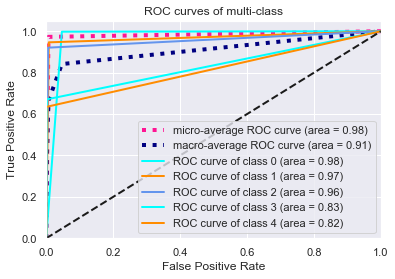

In [42]:
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
# Binarize the output
y_test = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
predicted = label_binarize(predicted, classes=[0, 1, 2, 3, 4])
n_classes = y_test.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predicted[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), predicted.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
lw = 2

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves of multi-class')
plt.legend(loc="lower right")
plt.show()

From ROC curves we see that AUC of class 0-5 are 0.98, 0.97, 0.96, 0.83, 0.82 respectively, and the AUC of the macro-average ROC curve is 0.91, which means our model is very successful

                    Objective 3: Build a model to predict the injury severity of a driver or passenger

For this objective, we need information from PERSON file and ACCIDENT file

In [43]:
ACCIDENT = pd.read_csv ('ACCIDENT.csv')
PERSON = pd.read_csv('PERSON.csv')

In [44]:
ACCIDENT_WEIGHT = ACCIDENT_WEIGHT[['CASENUM','WKDY_IM', 'HOUR_IM', 'EVENT1_IM', 'MANCOL_IM', 'RELJCT1_IM', 'RELJCT2_IM',
       'LGTCON_IM', 'WEATHR_IM']]
ACCIDENT_WEIGHT = ACCIDENT_WEIGHT.loc[ACCIDENT_WEIGHT['EVENT1_IM'].isin([12,14,11,34,30,42,33,1,24,8,59,38,35,9,25])]
ACCIDENT_WEIGHT.loc[ACCIDENT_WEIGHT['HOUR_IM'].isin([6,7,8,9,10,11,12,13,14,15,16,17,18,19]), 'HOUR_IM'] = 0
ACCIDENT_WEIGHT.loc[ACCIDENT_WEIGHT['HOUR_IM'].isin([20,21,22,23,24,1,2,3,4,5]), 'HOUR_IM'] = 1
ACCIDENT_WEIGHT.loc[ACCIDENT_WEIGHT['WKDY_IM'].isin([2,3,4,5,6]), 'WKDY_IM'] = 0
ACCIDENT_WEIGHT.loc[ACCIDENT_WEIGHT['WKDY_IM'].isin([1,7]), 'WKDY_IM'] = 1

In [45]:
PERSON.columns

Index(['CASENUM', 'VE_FORMS', 'VEH_NO', 'PER_NO', 'REGION', 'PSU', 'PJ',
       'PSU_VAR', 'URBANICITY', 'STRATUM', 'STR_VEH', 'MONTH', 'HOUR',
       'MINUTE', 'HARM_EV', 'MAN_COLL', 'SCH_BUS', 'MAKE', 'BODY_TYP',
       'MOD_YEAR', 'MAK_MOD', 'TOW_VEH', 'SPEC_USE', 'EMER_USE', 'ROLLOVER',
       'IMPACT1', 'FIRE_EXP', 'AGE', 'SEX', 'PER_TYP', 'INJ_SEV', 'SEAT_POS',
       'REST_USE', 'REST_MIS', 'AIR_BAG', 'EJECTION', 'DRINKING', 'ALC_STATUS',
       'ATST_TYP', 'ALC_RES', 'DRUGS', 'HOSPITAL', 'P_SF1', 'P_SF2', 'P_SF3',
       'LOCATION', 'SEX_IM', 'INJSEV_IM', 'EJECT_IM', 'PERALCH_IM', 'SEAT_IM',
       'AGE_IM', 'PSUSTRAT', 'WEIGHT'],
      dtype='object')

In [46]:
PERSON = PERSON[['CASENUM','PER_TYP','SEX_IM', 'INJSEV_IM', 'EJECT_IM', 'PERALCH_IM', 'SEAT_IM',
       'AGE_IM']]
PERSON.SEX_IM.replace({2: 0}, inplace=True)
PERSON = PERSON.loc[PERSON.INJSEV_IM<=4]

In [47]:
ACC_PER = pd.merge(ACCIDENT_WEIGHT,PERSON)
ACC_PER.shape

(562446, 16)

Since we only focus on the driver and passenger in a vehicle, we will remove other person type in our file

In [48]:
ACC_PER.PER_TYP.value_counts()

1     416872
2     138127
5       2813
3       2535
6       1854
9        226
10        14
7          4
8          1
Name: PER_TYP, dtype: int64

In [49]:
ACC_PER = ACC_PER[(ACC_PER.PER_TYP == 1) | (ACC_PER.PER_TYP == 2)]

In [50]:
ACC_PER.PERALCH_IM.value_counts()

0    545884
1      9115
Name: PERALCH_IM, dtype: int64

In [51]:
# Get dummies
ACC_PER_DUMMY = ACC_PER[['WKDY_IM', 'HOUR_IM', 'EVENT1_IM', 'MANCOL_IM', 'RELJCT1_IM',
       'RELJCT2_IM', 'LGTCON_IM', 'WEATHR_IM',  'SEX_IM',
       'INJSEV_IM', 'EJECT_IM', 'PERALCH_IM', 'SEAT_IM', 'AGE_IM']]
ACC_PER_DUMMY = pd.get_dummies(data = ACC_PER_DUMMY, columns = ['EVENT1_IM', 'MANCOL_IM', 
        'RELJCT1_IM','RELJCT2_IM', 'LGTCON_IM', 'WEATHR_IM','EJECT_IM','SEAT_IM']).copy()
ACC_PER_DUMMY.shape  # Totally 88 variables

(554999, 89)

In [52]:
ACC_PER_DUMMY.reset_index(inplace = True)

In [53]:
ACC_PER_DUMMY.corr()['INJSEV_IM'].sort_values()

EJECT_IM_0      -0.224148
MANCOL_IM_7     -0.090776
EVENT1_IM_12    -0.086381
MANCOL_IM_1     -0.074652
RELJCT2_IM_3    -0.064269
LGTCON_IM_1     -0.041844
SEX_IM          -0.038768
EVENT1_IM_11    -0.033797
MANCOL_IM_9     -0.023679
EVENT1_IM_8     -0.020070
EVENT1_IM_9     -0.018869
RELJCT2_IM_8    -0.016294
RELJCT2_IM_20   -0.015279
RELJCT2_IM_4    -0.012583
MANCOL_IM_11    -0.011581
MANCOL_IM_10    -0.010904
EVENT1_IM_14    -0.009361
WEATHR_IM_2     -0.008898
SEAT_IM_11      -0.008828
SEAT_IM_22      -0.007738
SEAT_IM_23      -0.006973
SEAT_IM_32      -0.006932
SEAT_IM_31      -0.006769
WEATHR_IM_12    -0.005131
RELJCT2_IM_18   -0.004653
RELJCT2_IM_6    -0.004646
SEAT_IM_41      -0.004284
SEAT_IM_33      -0.004098
MANCOL_IM_8     -0.003975
LGTCON_IM_7     -0.003417
SEAT_IM_21      -0.003403
RELJCT2_IM_7    -0.003083
RELJCT1_IM_0    -0.002985
WEATHR_IM_7     -0.002397
WEATHR_IM_10    -0.002225
SEAT_IM_54      -0.001958
SEAT_IM_43      -0.001537
WEATHR_IM_4     -0.001510
SEAT_IM_38  

In [64]:
# split our data
X = ACC_PER_DUMMY.drop(['INJSEV_IM'], axis=1).values
y = ACC_PER_DUMMY['INJSEV_IM'].values

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=123)
X_train, X_test, y_train, y_test

(array([[528306,      0,      0, ...,      0,      0,      0],
        [421175,      1,      0, ...,      0,      0,      0],
        [397906,      0,      1, ...,      0,      0,      0],
        ...,
        [ 17954,      1,      0, ...,      0,      0,      0],
        [ 28315,      0,      0, ...,      0,      0,      0],
        [280343,      1,      0, ...,      0,      0,      0]], dtype=int64),
 array([[474008,      0,      0, ...,      0,      0,      0],
        [217889,      0,      0, ...,      0,      0,      0],
        [273577,      0,      1, ...,      0,      0,      0],
        ...,
        [ 94421,      1,      1, ...,      0,      0,      0],
        [ 59410,      0,      0, ...,      0,      0,      0],
        [420335,      0,      0, ...,      0,      0,      0]], dtype=int64),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 array([0, 0, 1, ..., 0, 0, 0], dtype=int64))

In [60]:
## Fit model
clf = LogisticRegression(max_iter = 10000, solver = 'newton-cg', multi_class = 'auto', random_state = 960420)
clf.fit(X_train, y_train)

## Generate predictions
predicted = clf.predict(X_test)
    
## Compare to actual outcomes and return precision
print('Precision: ', (round(precision_score(y_test, predicted,average='micro')*100,1)))
report = sklearn.metrics.classification_report(y_test, predicted)
print(report)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


Precision:  84.1
              precision    recall  f1-score   support

           0       0.84      1.00      0.91    116454
           1       0.20      0.00      0.00     14284
           2       0.39      0.04      0.07      6322
           3       0.43      0.05      0.08      1467
           4       0.42      0.04      0.08       223

    accuracy                           0.84    138750
   macro avg       0.46      0.23      0.23    138750
weighted avg       0.75      0.84      0.77    138750



In [59]:
clf = MLPClassifier(random_state = 1)
clf.fit(X_train, y_train)

## Generate predictions
predicted = clf.predict(X_test)
    
## Compare to actual outcomes and return precision
print('Precision: ', (round(precision_score(y_test, predicted,average='micro')*100,1)))
report = sklearn.metrics.classification_report(y_test, predicted)
print(report)

Precision:  83.9
              precision    recall  f1-score   support

           0       0.84      1.00      0.91    116454
           1       0.71      0.00      0.00     14284
           2       1.00      0.00      0.00      6322
           3       0.00      0.00      0.00      1467
           4       0.00      0.00      0.00       223

    accuracy                           0.84    138750
   macro avg       0.51      0.20      0.18    138750
weighted avg       0.82      0.84      0.77    138750



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [65]:
select = sklearn.feature_selection.SelectKBest(k= 50)
clf = sklearn.ensemble.RandomForestClassifier(random_state=121, n_estimators = 100)

steps = [('feature_selection', select),
         ('random_forest', clf)]

pipeline.fit(X_train, y_train) # fit your pipeline on X_train and y_train
predicted = pipeline.predict(X_test ) # call pipeline.predict() on your X_test data to make a set of test predictions
report = sklearn.metrics.classification_report( y_test, predicted ) # test your predictions using sklearn.classification_report()
print(report) # and print the report

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    116454
           1       0.96      0.89      0.92     14284
           2       0.94      0.89      0.91      6322
           3       0.87      0.65      0.74      1467
           4       0.81      0.61      0.69       223

    accuracy                           0.98    138750
   macro avg       0.91      0.81      0.85    138750
weighted avg       0.98      0.98      0.97    138750



In [66]:
print('Precision: ', (round(precision_score(y_test, predicted,average = 'micro')*100,1)))

Precision:  97.6


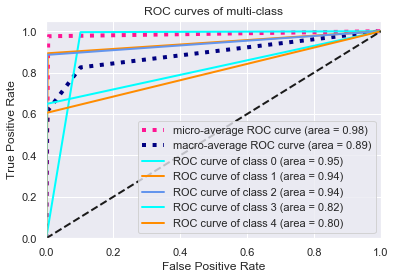

In [67]:
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
# Binarize the output
y_test = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
predicted = label_binarize(predicted, classes=[0, 1, 2, 3, 4])
n_classes = y_test.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predicted[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), predicted.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
lw = 2

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves of multi-class')
plt.legend(loc="lower right")
plt.show()

In [62]:
#######################################################################   ##   ##   ######################################
#######################################################################  #### ####  ######################################
############################################ The End ###################  ######  ########################################
#########################################################################  ####  #########################################
#########################################################################   #  ##################### Apr 2020 ############